In [262]:
import numpy as np
from time import time

# Used for molecular analysis
from rdkit import Chem
from rdkit import RDLogger 
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem.AllChem import GenerateDepictionMatching3DStructure
from rdkit.Chem import Descriptors

# Used for k-means clustering
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score

In [263]:
RDLogger.DisableLog('rdApp.*')
np.random.seed(42)

In [264]:
def load_data():
    data_file = 'data/molecule_data.csv'
    mol_df = pd.read_csv(data_file)

    smiles = np.array(mol_df['smiles'])
    labels = np.array(mol_df['labels']) 
    mols = np.array([Chem.MolFromSmiles(smile) for smile in smiles])
    return mols, labels

In [265]:
load_data()

(array([<rdkit.Chem.rdchem.Mol object at 0x7fab85e8a710>,
        <rdkit.Chem.rdchem.Mol object at 0x7fab85e8f1c0>, ...,
        <rdkit.Chem.rdchem.Mol object at 0x7fab84facc10>], dtype=object),
 array([1, 1, 1, ..., 0, 0, 0]))

In [266]:
# Printing out what the molecules look like in 2D
def draw_data(mols):
    img_2D = Draw.MolsToGridImage(mols, molsPerRow=6, maxMols=10)
    return img_2D

/opt/anaconda3/envs/LLNL/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  % (maxMols))


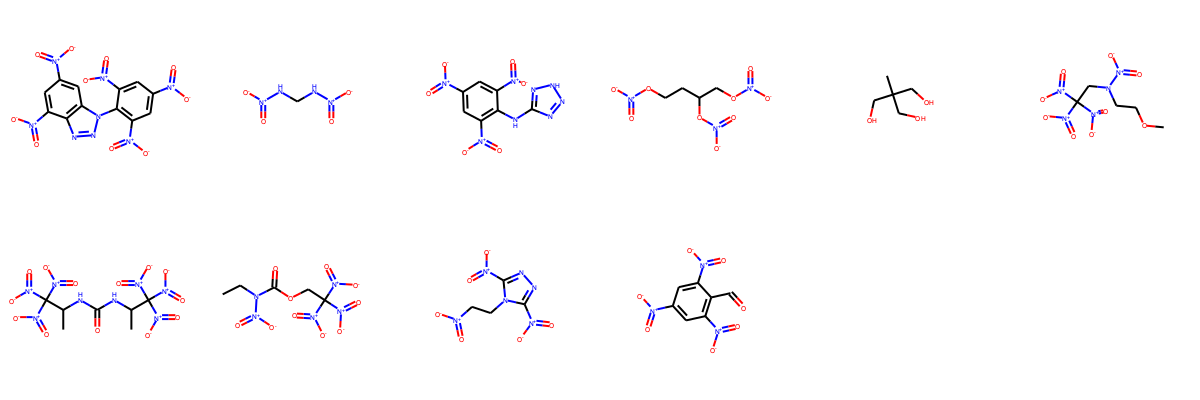

In [267]:
draw_data(mols)

In [268]:
# Acquiring the fingerprints of the molecules and checking similarity between 2 molecules
def generate_fingerprints(mols):
    f_prints = [Chem.RDKFingerprint(mol) for mol in mols]  
    return f_prints

In [269]:
f_prints = generate_fingerprints(mols)
f_prints_size = len(f_prints) 

4187

In [281]:
# Acquiring the MACCS fingerprints of the molecules and checking similarity between 2 molecules
def generate_MACCS(mols):
    MACCS_keys = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
    return MACCS_keys

In [282]:
mol_MACCS = generate_MACCS(mols)
f_prints_size = len(f_prints) 

In [283]:
# Finds the similarity score between two fingerprints
def find_similarity(f_print1, f_print2):
    similarity = DataStructs.FingerprintSimilarity(f_print1,f_print2, metric=DataStructs.DiceSimilarity)
    return similarity

In [284]:
find_similarity(f_prints[0], f_prints[1])
find_similarity(mol_MACCS[0], mol_MACCS[1])

0.6190476190476191

In [274]:
# Cross validation process
mol_train, mol_test, label_train, label_test = train_test_split(f_prints, labels, \
                                                                    test_size=0.2, shuffle=True)
mol_train_size = len(mol_train)
mol_test_size = len(mol_test)

In [275]:
# Using a k-means ML algorithm to generate a model
def bench_k_means(estimator, name, data, labels):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=mol_train_size)))

In [276]:
# Checks k means clustering algorithm for similarity
bench_k_means(KMeans(init='k-means++', n_clusters=2, n_init=10),
              name="k-means++", data=mol_train, labels=label_train)

k-means++	30.85s	1292204	0.080	0.026	0.039	-0.013	0.038	0.137


In [277]:
# Checks k means clustering algorithm for similarity using random initialization
bench_k_means(KMeans(init='random', n_clusters=2, n_init=10),
              name="random", data=mol_train, labels=label_train)

random   	28.69s	1292203	0.079	0.026	0.039	-0.014	0.038	0.137


In [278]:
reduced_data = PCA(n_components=2).fit_transform(f_prints)
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Text(0.5, 1.0, 'K-means clustering on the digits dataset (PCA-reduced data)\nCentroids are marked with white cross')

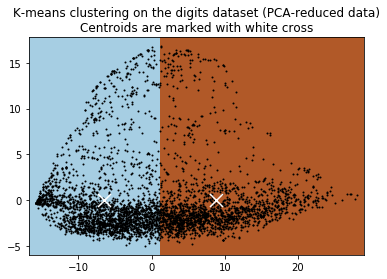

In [279]:
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')